# Convolutional Neural Network to Identify MNIST Digits

## Setup and Exploratory Data Analysis

In [7]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Let's see if we can have any GPUs we can use with this model.  

In [8]:
devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  details = tf.config.experimental.get_device_details(gpus[0])
  print("GPU details: ", details)


Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details:  {'device_name': 'METAL'}


Here we define some constants that we will use later.

In [9]:
RANDOM_SEED = 0
keras.utils.set_random_seed(RANDOM_SEED)
TRAINING_SIZE = 50_000
VALIDATION_SIZE = 10_000
NUM_EPOCHS = 30
BATCH_SIZE = 64

Load and split the data into train, test and validation sets.  

In [10]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [11]:
X_train_full.shape, y_train_full.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [12]:
assert X_train_full.shape[0] >= TRAINING_SIZE + VALIDATION_SIZE
X_train_full = X_train_full.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

In [13]:
X_valid, X_train = X_train_full[:VALIDATION_SIZE], X_train_full[VALIDATION_SIZE:TRAINING_SIZE + VALIDATION_SIZE]
y_valid, y_train = y_train_full[:VALIDATION_SIZE], y_train_full[VALIDATION_SIZE:TRAINING_SIZE + VALIDATION_SIZE]

Let's draw a block of digits and overlay the labels.  

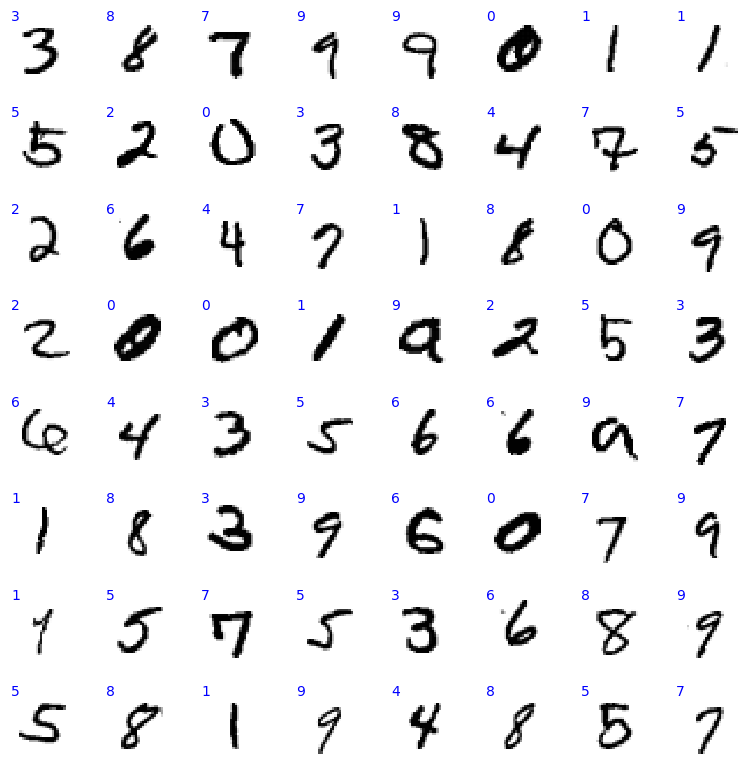

In [14]:
n_rows = 8
n_cols = 8
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis("off")
        plt.text(.1, .9, y_train[index], color="blue")
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

## Building the Model

In [15]:
model = keras.Sequential()

model.add(keras.layers.Conv2D(
    filters=32, kernel_size=(5, 5),
    strides=(1, 1), padding="same",
    data_format="channels_last",
    name="conv_1", activation="relu"))

model.add(keras.layers.MaxPool2D(pool_size=(2, 2), name="pool_1"))
    
model.add(keras.layers.Conv2D(
    filters=64, kernel_size=(5, 5),
    strides=(1, 1), padding="same",
    name="conv_2", activation="relu"))

model.add(keras.layers.MaxPool2D(pool_size=(2, 2), name="pool_2"))

In [16]:
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(
    units=128, name="fc_1", 
    activation="relu"))

model.add(keras.layers.Dropout(
    rate=0.5))
    
model.add(keras.layers.Dense(
    units=10, name="fc_2",
    activation="softmax"))

2025-06-09 11:57:33.877165: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-06-09 11:57:33.877333: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-06-09 11:57:33.877355: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
I0000 00:00:1749491853.877842 8846544 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1749491853.877906 8846544 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
model.build(input_shape=(None, 28, 28, 1))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 28, 28, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 14, 14, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_1 (Dense)                    │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_2 (Dense)                    │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 454,922 (1.74 MB)

 Trainable params: 454,922 (1.74 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training

You can select the appropriate processor below:

In [18]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
with tf.device("GPU: 0"):
    history = model.fit(X_train, y_train, epochs=NUM_EPOCHS, validation_data=(X_valid, y_valid), batch_size=BATCH_SIZE)

Epoch 1/30


2025-06-09 11:57:34.455446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.7830 - loss: 0.8094 - val_accuracy: 0.9750 - val_loss: 0.1054
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.9598 - loss: 0.1739 - val_accuracy: 0.9815 - val_loss: 0.0905
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.9713 - loss: 0.1254 - val_accuracy: 0.9821 - val_loss: 0.0992
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.9770 - loss: 0.0991 - val_accuracy: 0.9837 - val_loss: 0.0764
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.9796 - loss: 0.0827 - val_accuracy: 0.9874 - val_loss: 0.0712
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.9809 - loss: 0.0838 - val_accuracy: 0.9867 - val_loss: 0.0723
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.9845 - loss: 0.0704 - val_accuracy: 0.9873 - val_loss: 0.0653
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.9842 - loss: 0.0764 - val_accurac

## Model Evaluation

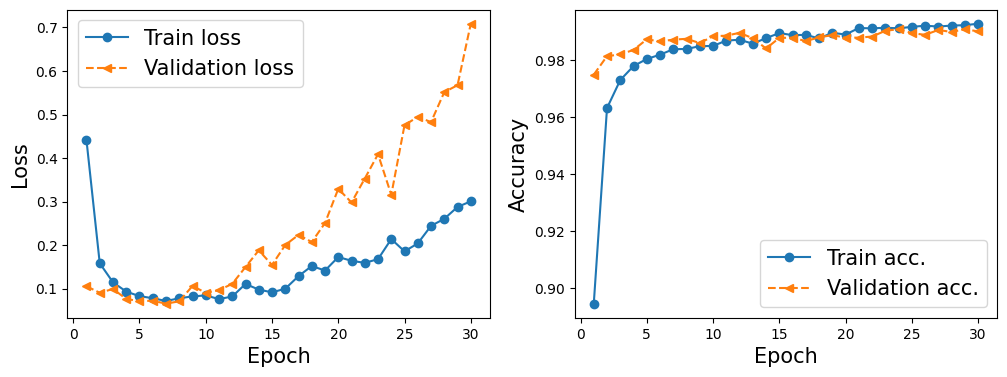

In [21]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

In [22]:
test_results = model.evaluate(X_test, y_test)
print(f"Test loss: {test_results[0]:.4f}, test acc: {test_results[1]:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9914 - loss: 0.5007
Test loss: 0.3997, test acc: 0.9930
